In [38]:
import pickle
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb

In [2]:
with open('dataframe.pkl', 'rb') as file:
    df = pickle.load(file)

In [3]:
df.head()

,FlagImpaye,Montant,DateTransaction,CodeDecision,VerifianceCPT1,VerifianceCPT2,VerifianceCPT3,D2CB,ScoringFP1,ScoringFP2,...,DiffDateTr3,CA3TRetMtt,CA3TR,Heure,Year,Month,Day,Hour,Minute,Second
0,0,20.00,2017-02-01 07:32:14,1,0,0,0,551,0.000000,0.000000,...,4.0,20.00,0.00,27134,2017,2,1,7,32,14
1,0,20.00,2017-02-01 07:43:37,1,0,0,0,551,0.000000,0.000000,...,4.0,28.61,8.61,27817,2017,2,1,7,43,37
2,0,57.64,2017-02-01 07:47:38,1,0,0,0,549,0.000000,0.000000,...,4.0,57.64,0.00,28058,2017,2,1,7,47,38
3,0,54.29,2017-02-01 07:48:48,0,1,1,1,267,0.000000,0.000000,...,4.0,54.29,0.00,28128,2017,2,1,7,48,48
4,0,26.90,2017-02-01 08:13:27,1,0,0,0,549,0.003769,8.586333,...,4.0,59.15,32.25,29607,2017,2,1,8,13,27


In [4]:
df.dtypes

FlagImpaye               category
Montant                   float64
DateTransaction    datetime64[ns]
CodeDecision                int32
VerifianceCPT1              int32
VerifianceCPT2              int32
VerifianceCPT3              int32
D2CB                        int32
ScoringFP1                float64
ScoringFP2                float64
ScoringFP3                float64
TauxImpNb_RB              float64
TauxImpNB_CPM             float64
EcartNumCheq                int32
NbrMagasin3J                int32
DiffDateTr1               float64
DiffDateTr2               float64
DiffDateTr3               float64
CA3TRetMtt                float64
CA3TR                     float64
Heure                       int32
Year                        int32
Month                       int32
Day                         int32
Hour                        int32
Minute                      int32
Second                      int32
dtype: object

# DataFrame réduit :

L objectif est de réduire notre dataframe pour faire les différentes méthodes afin d avancer plus rapidement

In [5]:
from sklearn.model_selection import train_test_split

# Séparez les données en fonction de la variable 'Flagimpaye'
df_pas_utilise, df_reduit = train_test_split(df, test_size=0.1, stratify=df['FlagImpaye'], random_state=42)

# Affichez la taille du sous-DataFrame de test pour vérifier
print("Taille du sous-DataFrame de test :", len(df_reduit))

Taille du sous-DataFrame de test : 464678


# Apprentissage et test:

In [6]:
# Définition des dates limites pour les ensembles d'apprentissage et de test
train_inf = '2017-02-01'
train_sup = '2017-08-31'
test_inf = '2017-09-01'
test_sup = '2017-11-30'

Apprentissage:

In [7]:
train = df_reduit.loc[(df_reduit['DateTransaction'] >= train_inf) & (df_reduit['DateTransaction'] <= train_sup)]

In [8]:
x_train = train.drop(columns=['FlagImpaye'])
y_train = train['FlagImpaye']

Test:

In [9]:
test = df_reduit.loc[(df_reduit['DateTransaction'] >= test_inf) & (df_reduit['DateTransaction'] <= test_sup)]

In [10]:
x_test = test.drop(columns=['FlagImpaye'])
y_test = test['FlagImpaye']

# Modèles suppervisés

In [11]:
import xgboost as xgb
from sklearn.metrics import classification_report

On enlève la colonne DateTransaction pour cette méthode car le type de données ne correspond pas

In [12]:
x_train = x_train.drop(columns=['DateTransaction'])

In [13]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 388491 entries, 1628857 to 3285815
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Montant         388491 non-null  float64
 1   CodeDecision    388491 non-null  int32  
 2   VerifianceCPT1  388491 non-null  int32  
 3   VerifianceCPT2  388491 non-null  int32  
 4   VerifianceCPT3  388491 non-null  int32  
 5   D2CB            388491 non-null  int32  
 6   ScoringFP1      388491 non-null  float64
 7   ScoringFP2      388491 non-null  float64
 8   ScoringFP3      388491 non-null  float64
 9   TauxImpNb_RB    388491 non-null  float64
 10  TauxImpNB_CPM   388491 non-null  float64
 11  EcartNumCheq    388491 non-null  int32  
 12  NbrMagasin3J    388491 non-null  int32  
 13  DiffDateTr1     388491 non-null  float64
 14  DiffDateTr2     388491 non-null  float64
 15  DiffDateTr3     388491 non-null  float64
 16  CA3TRetMtt      388491 non-null  float64
 17  CA3TR   

In [14]:
x_test = x_test.drop(columns=['DateTransaction'])

In [15]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74121 entries, 3946948 to 4147892
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Montant         74121 non-null  float64
 1   CodeDecision    74121 non-null  int32  
 2   VerifianceCPT1  74121 non-null  int32  
 3   VerifianceCPT2  74121 non-null  int32  
 4   VerifianceCPT3  74121 non-null  int32  
 5   D2CB            74121 non-null  int32  
 6   ScoringFP1      74121 non-null  float64
 7   ScoringFP2      74121 non-null  float64
 8   ScoringFP3      74121 non-null  float64
 9   TauxImpNb_RB    74121 non-null  float64
 10  TauxImpNB_CPM   74121 non-null  float64
 11  EcartNumCheq    74121 non-null  int32  
 12  NbrMagasin3J    74121 non-null  int32  
 13  DiffDateTr1     74121 non-null  float64
 14  DiffDateTr2     74121 non-null  float64
 15  DiffDateTr3     74121 non-null  float64
 16  CA3TRetMtt      74121 non-null  float64
 17  CA3TR           74121 non-nu

In [16]:
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours, NearMiss, ClusterCentroids

Voice la fréquence de chaque classe de FlagImpaye avant under-sampling :

In [17]:
freq = df_reduit['FlagImpaye'].value_counts()

# Convertissez la série en DataFrame pour une meilleure présentation
freq_df = pd.DataFrame(freq)

# Donnez un nom approprié à la colonne
freq_df.columns = ['Fréquence']

freq_df['Fréquence'] = freq_df['Fréquence'] / freq_df['Fréquence'].sum()
# Affichez le DataFrame de la table de fréquence
print(freq_df)

            Fréquence
FlagImpaye           
0            0.993544
1            0.006456


### Random Under-sampling

In [49]:
rus = RandomUnderSampler(random_state=42)
x_train_rus, y_train_rus = rus.fit_resample(x_train, y_train)
x_test_rus, y_test_rus = rus.fit_resample(x_test, y_test)

In [50]:
# Stratégie de validation croisée temporelle
tscv = TimeSeriesSplit(n_splits=5) 

In [51]:
# Paramètres à optimiser
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 15],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [2,4]
}

Fréquences:

In [52]:
freq_rus = y_train_rus.value_counts()

# Convertissez la série en DataFrame pour une meilleure présentation
freq_rus = pd.DataFrame(freq_rus)

# Donnez un nom approprié à la colonne
freq_rus.columns = ['Fréquence']

freq_rus['Fréquence'] = freq_rus['Fréquence'] / freq_rus['Fréquence'].sum()
# Affichez le DataFrame de la table de fréquence
print(freq_rus)

            Fréquence
FlagImpaye           
0                 0.5
1                 0.5


<Axes: title={'center': 'Count (target)'}, xlabel='FlagImpaye'>

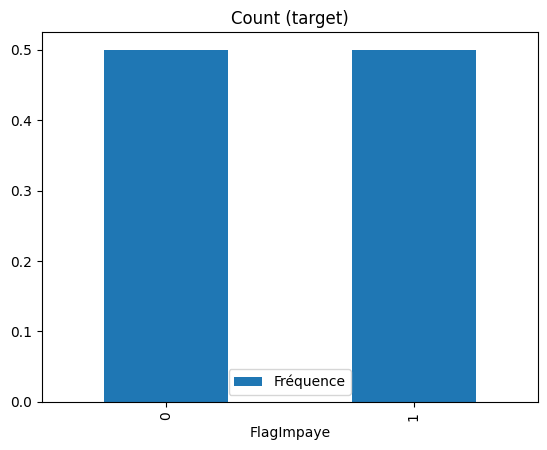

In [82]:
freq_rus.plot(kind='bar', title='Count (target)')

### Random Under-sampling avec XGBoost

In [59]:
model = xgb.XGBClassifier()

# GridSearchCV avec validation croisée temporelle
grid_search = GridSearchCV(model, param_grid, refit = True, scoring='f1', cv=tscv)

model.fit(x_train_rus, y_train_rus)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [57]:
# Afficher les meilleurs paramètres et la meilleure performance
print("Meilleurs paramètres : ", grid_search.best_params_)
print("Meilleur score F1 : ", grid_search.best_score_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [48]:
y_pred = model.predict(x_test_rus)

precision, recall, f1, _ = precision_recall_fscore_support(y_test_rus, y_pred, average='binary')

print(f'F1 Score: {f1}')

F1 Score: 0.8622568093385214


### Tomek Link

In [25]:
tl = TomekLinks()
x_train_tl, y_train_tl = tl.fit_resample(x_train, y_train)
x_test_tl, y_test_tl = tl.fit_resample(x_test, y_test)

Fréquences :

In [26]:
freq_tl = y_train_tl.value_counts()

# Convertir la série en DataFrame pour une meilleure présentation
freq_tl = pd.DataFrame(freq_tl)

# Donner un nom approprié à la colonne
freq_tl.columns = ['Fréquence']

freq_tl['Fréquence'] = freq_tl['Fréquence'] / freq_tl['Fréquence'].sum()
# Afficher le DataFrame de la table de fréquence
print(freq_tl)

            Fréquence
FlagImpaye           
0            0.994043
1            0.005957


<Axes: title={'center': 'Count (target)'}, xlabel='FlagImpaye'>

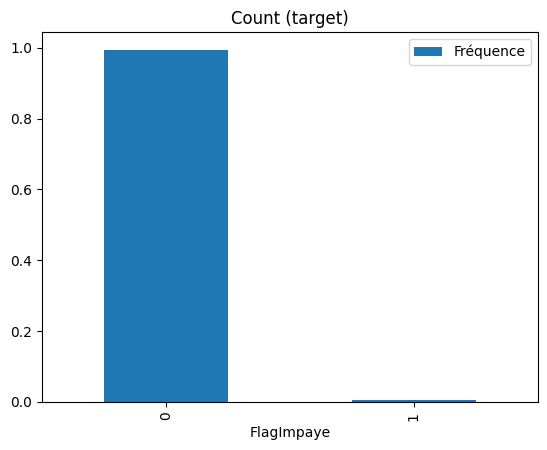

In [87]:
freq_tl.plot(kind='bar', title='Count (target)')

### Tomek Link avec XGBoost

In [27]:
model = xgb.XGBClassifier()
model.fit(x_train_tl, y_train_tl)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [28]:
y_pred = model.predict(x_test_tl)

precision, recall, f1, _ = precision_recall_fscore_support(y_test_tl, y_pred, average='binary')

print(f'F1 Score: {f1}')

F1 Score: 0.8048568950563747


### Edited Nearest Neighbours

In [29]:
enn = EditedNearestNeighbours(n_neighbors=3)
x_train_enn, y_train_enn = enn.fit_resample(x_train, y_train)
x_test_enn, y_test_enn = enn.fit_resample(x_test, y_test)

Fréquences :

In [30]:
freq_enn = y_train_enn.value_counts()

# Convertir la série en DataFrame pour une meilleure présentation
freq_enn = pd.DataFrame(freq_enn)

# Donner un nom approprié à la colonne
freq_enn.columns = ['Fréquence']

freq_enn['Fréquence'] = freq_enn['Fréquence'] / freq_enn['Fréquence'].sum()
# Afficher le DataFrame de la table de fréquence
print(freq_enn)

            Fréquence
FlagImpaye           
0            0.993968
1            0.006032


<Axes: title={'center': 'Count (target)'}, xlabel='FlagImpaye'>

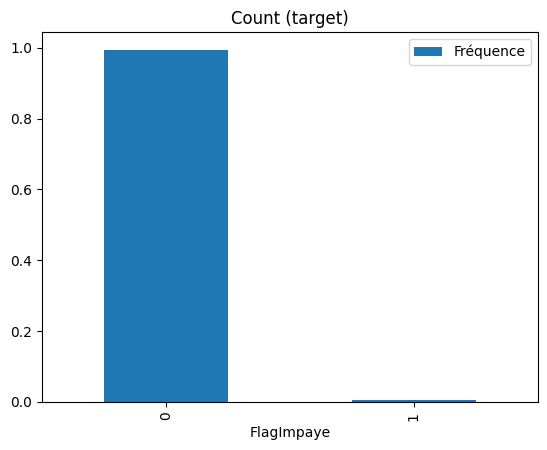

In [92]:
freq_enn.plot(kind='bar', title='Count (target)')

### Edited Nearest Neighbours avec XGBoost

In [31]:
model = xgb.XGBClassifier()
model.fit(x_train_enn, y_train_enn)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [32]:
y_pred = model.predict(x_test_enn)

precision, recall, f1, _ = precision_recall_fscore_support(y_test_enn, y_pred, average='binary')

print(f'F1 Score: {f1}')

F1 Score: 0.8089500860585197


### NearMiss

In [33]:
x_train_nm, y_train_nm = NearMiss().fit_resample(x_train, y_train)
x_test_nm, y_test_nm = NearMiss().fit_resample(x_test, y_test)

Fréquences :

In [35]:
freq_nm= y_train_nm.value_counts()

# Convertir la série en DataFrame pour une meilleure présentation
freq_nm = pd.DataFrame(freq_nm)

# Donner un nom approprié à la colonne
freq_nm.columns = ['Fréquence']

freq_nm['Fréquence'] = freq_nm['Fréquence'] / freq_nm['Fréquence'].sum()
# Afficher le DataFrame de la table de fréquence
print(freq_nm)

            Fréquence
FlagImpaye           
0                 0.5
1                 0.5


<Axes: title={'center': 'Count (target)'}, xlabel='FlagImpaye'>

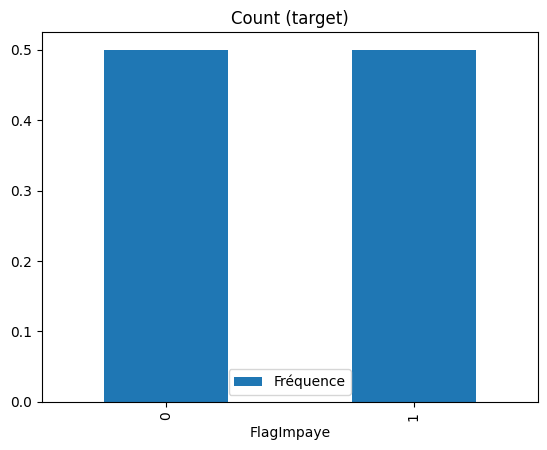

In [106]:
freq_nm.plot(kind='bar', title='Count (target)')

### NearMiss avec XGBoost

In [36]:
model = xgb.XGBClassifier()
model.fit(x_train_nm, y_train_nm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [37]:
y_pred = model.predict(x_test_nm)

precision, recall, f1, _ = precision_recall_fscore_support(y_test_nm, y_pred, average='binary')

print(f'F1 Score: {f1}')

F1 Score: 0.8872936109117013


## Decision Tree

In [109]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import f1_score

In [110]:
# Modèle de l'arbre de décision
dt_classifier = DecisionTreeClassifier()

### Decision tree avec Random Under-Sampling

In [112]:
# Entraîner le modèle sur l'ensemble d'entraînement
dt_classifier.fit(x_train_rus, y_train_rus)

# Faire des prédictions sur l'ensemble de test
y_pred = dt_classifier.predict(x_test_rus)

# Évaluer les performances du modèle
f1 = f1_score(y_test_rus, y_pred)
print(f"F1 Score: {f1}")

F1 Score: 0.8209606986899564


### Decision tree avec Tomek Link

In [113]:
# Entraîner le modèle sur l'ensemble d'entraînement
dt_classifier.fit(x_train_tl, y_train_tl)

# Faire des prédictions sur l'ensemble de test
y_pred = dt_classifier.predict(x_test_tl)

# Évaluer les performances du modèle
f1 = f1_score(y_test_tl, y_pred)
print(f"F1 Score: {f1}")

F1 Score: 0.666191155492154


### Decision tree avec Edited Nearest Neighbours

In [114]:
# Entraîner le modèle sur l'ensemble d'entraînement
dt_classifier.fit(x_train_enn, y_train_enn)

# Faire des prédictions sur l'ensemble de test
y_pred = dt_classifier.predict(x_test_enn)

# Évaluer les performances du modèle
f1 = f1_score(y_test_enn, y_pred)
print(f"F1 Score: {f1}")

F1 Score: 0.682643427741467


### Decision tree avec NearMiss

In [116]:
# Entraîner le modèle sur l'ensemble d'entraînement
dt_classifier.fit(x_train_nm, y_train_nm)

# Faire des prédictions sur l'ensemble de test
y_pred = dt_classifier.predict(x_test_nm)

# Évaluer les performances du modèle
f1 = f1_score(y_test_nm, y_pred)
print(f"F1 Score: {f1}")

F1 Score: 0.8342391304347826


Le meilleur est donc pour l'instant celui avec Tomek Link

## Gridsearch

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

### Gridsearch avec Random Under-Sampling

In [39]:
# Pipeline
pipeline = Pipeline([
    ('classifier', dt_classifier)
])

# Paramètres pour la recherche sur la grille
param_grid = {
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [5, 10],
    'classifier__min_samples_leaf': [2, 4]
}

# Recherche sur la grille
grid_search = GridSearchCV(pipeline, param_grid, scoring='f1', cv=5)
grid_search.fit(x_train_rus, y_train_rus)

# Afficher les meilleurs paramètres et le meilleur score F1
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleur score F1:", grid_search.best_score_)

Meilleurs paramètres: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5}
Meilleur score F1: 0.8729769065625061


In [40]:
y_pred = grid_search.predict(x_test)

# Évaluer les performances du modèle
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

F1 Score: 0.10013836042891733


In [41]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

conf_matrix

array([[63136, 10307],
       [   99,   579]], dtype=int64)

### Gridsearch avec Tomek Link

In [42]:
# Pipeline
pipeline = Pipeline([
    ('classifier', dt_classifier)
])

# Paramètres pour la recherche sur la grille
param_grid = {
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [5, 10],
    'classifier__min_samples_leaf': [2, 4]
}

# Recherche sur la grille
grid_search = GridSearchCV(pipeline, param_grid, scoring='f1', cv=5)
grid_search.fit(x_train_tl, y_train_tl)

# Afficher les meilleurs paramètres et le meilleur score F1
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleur score F1:", grid_search.best_score_)

Meilleurs paramètres: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5}
Meilleur score F1: 0.7780371337449985


In [43]:
y_pred = grid_search.predict(x_test)

# Évaluer les performances du modèle
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

F1 Score: 0.8079242032730405


In [44]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

conf_matrix

array([[73429,    14],
       [  209,   469]], dtype=int64)

### Gridsearch avec Edited Nearest Neighbours

In [46]:
# Pipeline
pipeline = Pipeline([
    ('classifier', dt_classifier)
])

# Paramètres pour la recherche sur la grille
param_grid = {
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [5, 10],
    'classifier__min_samples_leaf': [2, 4]
}

# Recherche sur la grille
grid_search = GridSearchCV(pipeline, param_grid, scoring='f1', cv=5)
grid_search.fit(x_train_enn, y_train_enn)

# Afficher les meilleurs paramètres et le meilleur score F1
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleur score F1:", grid_search.best_score_)

Meilleurs paramètres: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10}
Meilleur score F1: 0.7784448743210616


In [47]:
y_pred = grid_search.predict(x_test)

# Évaluer les performances du modèle
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

F1 Score: 0.8086206896551724


In [48]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

conf_matrix

array([[73430,    13],
       [  209,   469]], dtype=int64)

### Gridsearch avec NearMiss

In [49]:
# Pipeline
pipeline = Pipeline([
    ('classifier', dt_classifier)
])

# Paramètres pour la recherche sur la grille
param_grid = {
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [5, 10],
    'classifier__min_samples_leaf': [2, 4]
}

# Recherche sur la grille
grid_search = GridSearchCV(pipeline, param_grid, scoring='f1', cv=5)
grid_search.fit(x_train_nm, y_train_nm)

# Afficher les meilleurs paramètres et le meilleur score F1
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleur score F1:", grid_search.best_score_)

Meilleurs paramètres: {'classifier__max_depth': 15, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 5}
Meilleur score F1: 0.9143329549436807


In [50]:
y_pred = grid_search.predict(x_test)

# Évaluer les performances du modèle
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

F1 Score: 0.02968388589051658


In [51]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

conf_matrix

array([[33233, 40210],
       [   62,   616]], dtype=int64)

Les modèles gridsearch ENN et TL sont les plus performants pour l'instant 